In [11]:
import nibabel as nib
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
from tensorflow.keras import layers, models, callbacks, metrics, Input, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from skimage.transform import rotate
import random
from scipy.ndimage import rotate, shift

In [12]:
# Função que carrega os dados com pares de imagens
def load_data_with_pairs(folder):
    if not os.path.exists(folder):
        print(f"A pasta {folder} não existe.")
        return {}, {}, {}, {}, {}

    images_by_group = {}
    mask_by_group = {}
    patient_ids = []

    # Itera sobre os pacientes no diretório
    for patient_id in tqdm(os.listdir(folder), desc="Carregamento de arquivos NIfTI..."):
        patient_path = os.path.join(folder, patient_id)

        areas_image = ["left", "right"]
        areas_mask = ["lesion_left", "lesion_right"]
        side_path_left = os.path.join(patient_path, areas_image[0])
        side_path_right = os.path.join(patient_path, areas_image[1])
        lesion_path_left = os.path.join(patient_path, areas_mask[0])
        lesion_path_right = os.path.join(patient_path, areas_mask[1])

        if patient_id not in images_by_group:
            images_by_group[patient_id] = {}
        if patient_id not in mask_by_group:
            mask_by_group[patient_id] = {}
        for type_image, type_mask in zip(areas_image, areas_mask):
            if type_image not in images_by_group[patient_id]:
                images_by_group[patient_id][type_image] = []
            if type_mask not in mask_by_group[patient_id]:
                mask_by_group[patient_id][type_mask] = []
            
            # Carrega as imagens e máscaras do lado esquerdo
            for patch_id, mask_id in zip(os.listdir(side_path_left), os.listdir(lesion_path_left)):
                img_path= os.path.join(side_path_left, patch_id)
                mask_path = os.path.join(lesion_path_left, mask_id)
                for img_path_left, mask_path_left in zip(os.listdir(img_path), os.listdir(mask_path)):
                    image_data_left = nib.load(os.path.join(img_path, img_path_left)).get_fdata()
                    mask_data_left = nib.load(os.path.join(mask_path, mask_path_left)).get_fdata()

                    # Rotacionar as fatias
                    rotated_slice_left = np.rot90(image_data_left, k=-1)
                    rotated_lesion_slice_left = np.rot90(mask_data_left, k=-1)

                    images_by_group[patient_id][type_image].append(rotated_slice_left)
                    mask_by_group[patient_id][type_mask].append(rotated_lesion_slice_left)

            # Carrega as imagens e máscaras do lado direito
            for patch_id, mask_id in zip(os.listdir(side_path_right), os.listdir(lesion_path_right)):
                img_path = os.path.join(side_path_right, patch_id)
                mask_path = os.path.join(lesion_path_right, mask_id)
                for img_path_right, mask_path_right in zip(os.listdir(img_path), os.listdir(mask_path)):
                    image_data_right = nib.load(os.path.join(img_path, img_path_right)).get_fdata()
                    mask_data_right = nib.load(os.path.join(mask_path, mask_path_right)).get_fdata()

                    # Rotacionar as fatias
                    rotated_slice_right = np.rot90(image_data_right, k=-1)
                    rotated_lesion_slice_right = np.rot90(mask_data_right, k=-1)
                    
                    images_by_group[patient_id][type_image].append(rotated_slice_right)
                    mask_by_group[patient_id][type_mask].append(rotated_lesion_slice_right)
        patient_ids.append(patient_id)

    # Estruturas para armazenar pares de imagens e máscaras (esquerdo e direito (contralateral))
    images_left = {}
    images_right = {}
    mask_left = {}
    mask_right = {}
    labels_pair = {}

    for patient_id in images_by_group.keys():
        images_left[patient_id] = []
        images_right[patient_id] = []
        mask_left[patient_id] = []
        mask_right[patient_id] = []
        labels_pair[patient_id] = []
        
        for patch_left_image, mask_left_image, patch_right_image, mask_right_image in zip(images_by_group[patient_id][list(images_by_group[patient_id].keys())[0]], mask_by_group[patient_id][list(mask_by_group[patient_id].keys())[0]], images_by_group[patient_id][list(images_by_group[patient_id].keys())[1]], mask_by_group[patient_id][list(mask_by_group[patient_id].keys())[1]]):
            images_left[patient_id].append(patch_left_image)
            images_right[patient_id].append(patch_right_image)
            mask_left[patient_id].append(mask_left_image)
            mask_right[patient_id].append(mask_right_image)
            
            # Determina se há lesão na máscara da imagem esquerda e na contralateral direita
            has_lesion_left  = np.any(mask_left_image == 1)
            has_lesion_right = np.any(mask_right_image == 1)
            
            # Define o label para o par com base na presença de lesão
            if has_lesion_left == False and has_lesion_right == False:
                labels_pair[patient_id].append(0)
            else:
                labels_pair[patient_id].append(1)

    print(f"Total de pacientes: {len(patient_ids)}")
    for patient_id, labels in labels_pair.items():
        print(f"Paciente {patient_id}: Total de pares de recortes: {len(labels)}")

    return images_left, images_right, labels_pair, mask_left, mask_right

In [13]:
def augment_image(image, augment_factor=2):
    augmented_images = []
    
    for _ in range(augment_factor):
        # Random rotation
        angle = random.uniform(-30, 30)
        rotated_image = rotate(image, angle, reshape=False)

        # Random shift
        shift_values = random.uniform(-5, 5)
        shifted_image = shift(rotated_image, shift_values)
        
        augmented_images.append(shifted_image)
        
    return augmented_images

def augment_data(images_left, images_right, labels, augment_factor=2):
    if (augment_factor==1):
        return images_left, images_right, labels
    
    augmented_images_left = []
    augmented_images_right = []
    augmented_labels = []
    
    for img_left, img_right, label in zip(images_left, images_right, labels):
        augmented_left = augment_image(img_left, augment_factor)
        augmented_right = augment_image(img_right, augment_factor)
        
        augmented_images_left.extend(augmented_left)
        augmented_images_right.extend(augmented_right)
        augmented_labels.extend([label] * augment_factor)
        
    return (augmented_images_left), (augmented_images_right), (augmented_labels)

In [14]:
# Função para filtrar as imagens por paciente
def select_by_patients(patients, all_images_original, all_images_opposite, all_labels):
    selected_images_original = []
    selected_images_opposite = []
    selected_labels = []
    
    for patient in patients:
        if patient in all_images_original and patient in all_images_opposite:
            selected_images_original.extend(all_images_original[patient])
            selected_images_opposite.extend(all_images_opposite[patient])
            selected_labels.extend(all_labels[patient])
        else:
            print(f"Paciente {patient} não encontrado em uma das listas de imagens.")
    
    return (selected_images_original), (selected_images_opposite), (selected_labels)

In [15]:
# Função para preparar os dados para treino, validação e teste
def prepare_data_for_training_balanced(images_left, images_right, labels_pair, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1, augment_factor=1):
    balanced_images_original = {}
    balanced_images_opposite = {}
    balanced_labels = {}
    balanced_mask_original = {}
    balanced_mask_opposite = {}

    for patient_id in images_left:
        class_1_labels = []
        class_0_labels = []
        class_1_left = {}
        class_0_left = {}
        class_1_right = {}
        class_0_right = {}
        class_1_mask_left = {}
        class_0_mask_left = {}
        class_1_mask_right = {}
        class_0_mask_right = {}
        
        class_1_left[patient_id] = []
        class_0_left[patient_id] = []
        class_1_right[patient_id] = []
        class_0_right[patient_id] = []
        class_1_mask_left[patient_id] = []
        class_0_mask_left[patient_id] = []
        class_1_mask_right[patient_id] = []
        class_0_mask_right[patient_id] = []
        index = 0
        
        # Iterar sobre os patches e dividir as classes 0 e 1 com base nas labels
        for label in labels_pair[patient_id]:
            image_left = (images_left[patient_id])[index]
            image_right = (images_right[patient_id])[index]
            mask_image_left = (mask_left[patient_id])[index]
            mask_image_right = (mask_right[patient_id])[index]
            index += 1
            
            if label == 1:
                class_1_labels.append(label)
                class_1_left[patient_id].append(image_left)
                class_1_right[patient_id].append(image_right)
                class_1_mask_left[patient_id].append(mask_image_left)
                class_1_mask_right[patient_id].append(mask_image_right)
            else:
                class_0_labels.append(label)
                class_0_left[patient_id].append(image_left)
                class_0_right[patient_id].append(image_right)
                class_0_mask_left[patient_id].append(mask_image_left)
                class_0_mask_right[patient_id].append(mask_image_right)
        
        class_1_count = len(class_1_labels)
        print(f"Paciente {patient_id}: Total de pares de recortes com labels 1: {class_1_count}")

        # Fazer undersampling da classe majoritária (label 0) para igualar ao número de exemplos da classe 1
        class_0_count = len(class_0_labels)
        if class_0_count > class_1_count:
            sampled_class_0_slices_left = (class_0_left[patient_id])[:class_1_count]
            sampled_class_0_slices_right = (class_0_right[patient_id])[:class_1_count]
            class_0_original_modified = {}
            class_0_original_modified[patient_id] = []
            class_0_opposite_modified = {}
            class_0_opposite_modified[patient_id] = []
            sampled_class_0_mask_left = (class_0_mask_left[patient_id])[:class_1_count]
            sampled_class_0_mask_right = (class_0_mask_right[patient_id])[:class_1_count]
            class_0_mask_original_modified = {}
            class_0_mask_original_modified[patient_id] = []
            class_0_mask_opposite_modified = {}
            class_0_mask_opposite_modified[patient_id] = []
            
            for left_image, left_mask in zip(sampled_class_0_slices_left, sampled_class_0_mask_left):
                class_0_original_modified[patient_id].append(left_image)
                class_0_mask_original_modified[patient_id].append(left_mask)
            for right_image, right_mask in zip(sampled_class_0_slices_right, sampled_class_0_mask_right):
                class_0_opposite_modified[patient_id].append(right_image)
                class_0_mask_opposite_modified[patient_id].append(right_mask)
            class_0_labels = [0] * class_1_count

        balanced_images_original[patient_id] = list(class_1_left[patient_id]) + list(class_0_original_modified[patient_id])
        balanced_images_opposite[patient_id] = list(class_1_right[patient_id]) + list(class_0_opposite_modified[patient_id])
        balanced_labels[patient_id] = class_1_labels + class_0_labels
        balanced_mask_original[patient_id] = list(class_1_mask_left[patient_id]) + list(class_0_mask_original_modified[patient_id])
        balanced_mask_opposite[patient_id] = list(class_1_mask_right[patient_id]) + list(class_0_mask_opposite_modified[patient_id])

    for patient_id, images in balanced_images_original.items():
        print(f"Paciente {patient_id}: Total de pares de recortes (label 1 + label 0): {len(images)}")
        
    # Separar os dados por conjunto (treino, validação, teste)
    patients = list(set(balanced_labels.keys()))
    train_patients, valtest_patients = train_test_split(patients, train_size = train_size)
    val_patients, test_patients = train_test_split(valtest_patients, train_size = validation_size / (validation_size + test_size))
        
    X_train_original, X_train_opposite, y_train = select_by_patients(train_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    X_val_original, X_val_opposite, y_val = select_by_patients(val_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    X_test_original, X_test_opposite, y_test = select_by_patients(test_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    mask_test_original, mask_test_opposite, _ = select_by_patients(test_patients, balanced_mask_original, balanced_mask_opposite, balanced_labels)

    # Aplicar data augmentation nas imagens
    X_train_original_, X_train_opposite_, y_train = augment_data(X_train_original, X_train_opposite, y_train, augment_factor=augment_factor)
    X_val_original_, X_val_opposite_, y_val = augment_data(X_val_original, X_val_opposite, y_val, augment_factor=augment_factor)
    X_test_original_, X_test_opposite_, y_test = augment_data(X_test_original, X_test_opposite, y_test, augment_factor=augment_factor)
    
    X_train_original_ = [img for img in X_train_original_ if len(img)>0 and img is not []]
    X_train_opposite_ = [img for img in X_train_opposite_ if len(img)>0 and img is not []]

    print(f"Total de pares de recortes no treino ({augment_factor}*{train_patients}) com label 1: {y_train.count(1)}")
    print(f"Total de pares de recortes no treino ({augment_factor}*{train_patients}) com label 0: {y_train.count(0)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{val_patients}) com label 1: {y_val.count(1)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{val_patients}) com label 0: {y_val.count(0)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{test_patients}) label 1: {y_test.count(1)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{test_patients}) label 0: {y_test.count(0)}")
    
    return np.array(X_train_original_), np.array(X_train_opposite_), np.array(X_val_original_), np.array(X_val_opposite_), np.array(X_test_original_), np.array(X_test_opposite_), np.array(y_train), np.array(y_val), np.array(y_test), np.array(X_test_original), np.array(X_test_opposite), np.array(mask_test_original), np.array(mask_test_opposite)

In [16]:
# Função para construir o modelo CNN 2D
def build_cnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), data_format="channels_last", activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(64, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.3))
        
    model.add(layers.Conv2D(128, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))

    return model

In [ ]:
# Função para construir a rede siamesa
def build_siamese_model(input_shape_original, input_shape_opposite):
    input_original = Input(shape=input_shape_original)
    input_opposite = Input(shape=input_shape_opposite)

    cnn_model = build_cnn_model(input_shape_original)
    output_original = cnn_model(input_original)
    cnn_model_opposite = build_cnn_model(input_shape_opposite)
    output_opposite = cnn_model_opposite(input_opposite)

    # Concatenar as duas saídas (Lado esquerdo + Contra-lateral)
    concatenated = layers.Concatenate()([output_original, output_opposite])
    concatenated = layers.BatchNormalization()(concatenated)
    
    output = layers.Dense(1, activation='sigmoid')(concatenated)
    
    siamese_model = Model(inputs=[input_original, input_opposite], outputs=output)
    siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(name="precision"), metrics.Recall(name="recall")])

    return siamese_model

In [18]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [19]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


In [20]:
input_folder = 'Contralateral'

# Carregar os dados
X_left, X_right, y, mask_left, mask_right = load_data_with_pairs(input_folder)

Carregamento de arquivos NIfTI...: 100%|██████████| 78/78 [35:18<00:00, 27.16s/it]


Total de pacientes: 78
Paciente sub-00001: Total de pares de recortes: 1824
Paciente sub-00003: Total de pares de recortes: 1824
Paciente sub-00004: Total de pares de recortes: 1824
Paciente sub-00006: Total de pares de recortes: 1824
Paciente sub-00009: Total de pares de recortes: 1824
Paciente sub-00010: Total de pares de recortes: 1824
Paciente sub-00014: Total de pares de recortes: 1824
Paciente sub-00015: Total de pares de recortes: 1824
Paciente sub-00016: Total de pares de recortes: 1824
Paciente sub-00020: Total de pares de recortes: 1824
Paciente sub-00024: Total de pares de recortes: 1824
Paciente sub-00032: Total de pares de recortes: 1824
Paciente sub-00033: Total de pares de recortes: 1824
Paciente sub-00034: Total de pares de recortes: 1824
Paciente sub-00038: Total de pares de recortes: 1824
Paciente sub-00040: Total de pares de recortes: 1824
Paciente sub-00043: Total de pares de recortes: 1824
Paciente sub-00044: Total de pares de recortes: 1824
Paciente sub-00047: Tot

In [45]:
# Preparar dados para treino, teste e validação
X_train_left, X_train_right, X_valid_left, X_valid_right, X_test_left, X_test_right, y_train, y_valid, y_test, X_test_left_sem_data_augment, X_test_right_sem_data_augment, mask_left_test, mask_right_test = prepare_data_for_training_balanced(X_left, X_right, y, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1)

# Adiciono camada de cor
X_train_left = np.expand_dims(X_train_left, axis=-1)
X_train_right = np.expand_dims(X_train_right, axis=-1)
X_valid_left = np.expand_dims(X_valid_left, axis=-1)
X_valid_right = np.expand_dims(X_valid_right, axis=-1)
X_test_left = np.expand_dims(X_test_left, axis=-1)
X_test_right = np.expand_dims(X_test_right, axis=-1)

# Normalizo os dados
X_train_left /= 255
X_train_right /= 255
X_valid_left /= 255
X_valid_right /= 255
X_test_left /= 255
X_test_right /= 255

Paciente sub-00001: Total de pares de recortes com labels 1: 50
Paciente sub-00003: Total de pares de recortes com labels 1: 68
Paciente sub-00004: Total de pares de recortes com labels 1: 64
Paciente sub-00006: Total de pares de recortes com labels 1: 18
Paciente sub-00009: Total de pares de recortes com labels 1: 60
Paciente sub-00010: Total de pares de recortes com labels 1: 144
Paciente sub-00014: Total de pares de recortes com labels 1: 56
Paciente sub-00015: Total de pares de recortes com labels 1: 118
Paciente sub-00016: Total de pares de recortes com labels 1: 226
Paciente sub-00020: Total de pares de recortes com labels 1: 58
Paciente sub-00024: Total de pares de recortes com labels 1: 28
Paciente sub-00032: Total de pares de recortes com labels 1: 68
Paciente sub-00033: Total de pares de recortes com labels 1: 66
Paciente sub-00034: Total de pares de recortes com labels 1: 6
Paciente sub-00038: Total de pares de recortes com labels 1: 28
Paciente sub-00040: Total de pares de 

In [48]:
# Construir e compilar o modelo CNN
input_shape_left = (X_train_left[1].shape)
input_shape_right = (X_train_right[1].shape)

siamese_model = build_siamese_model(input_shape_left, input_shape_right)
siamese_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 70, 70, 1)]          0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 70, 70, 1)]          0         []                            
                                                                                                  
 sequential_10 (Sequential)  (None, 128)                  895616    ['input_11[0][0]']            
                                                                                                  
 sequential_11 (Sequential)  (None, 128)                  895616    ['input_12[0][0]']            
                                                                                            

In [49]:
# Adicionar o callback EarlyStopping e low rate scheduler
# early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Treinamento do modelo  
history = siamese_model.fit([X_train_left, X_train_right], y_train, validation_data=([X_valid_left, X_valid_right], y_valid), batch_size=64, epochs=120)

Epoch 1/120
101/101 [==============================] - 21s 195ms/step - loss: 0.6708 - accuracy: 0.6611 - precision: 0.6594 - recall: 0.6666 - val_loss: 0.5787 - val_accuracy: 0.7224 - val_precision: 0.8175 - val_recall: 0.5725
Epoch 2/120
101/101 [==============================] - 20s 195ms/step - loss: 0.3938 - accuracy: 0.8212 - precision: 0.8348 - recall: 0.8009 - val_loss: 0.7895 - val_accuracy: 0.7396 - val_precision: 1.0000 - val_recall: 0.4791
Epoch 3/120
101/101 [==============================] - 21s 205ms/step - loss: 0.3099 - accuracy: 0.8656 - precision: 0.8817 - recall: 0.8446 - val_loss: 0.8010 - val_accuracy: 0.6634 - val_precision: 1.0000 - val_recall: 0.3268
Epoch 4/120
101/101 [==============================] - 20s 198ms/step - loss: 0.2180 - accuracy: 0.9050 - precision: 0.9211 - recall: 0.8858 - val_loss: 0.5547 - val_accuracy: 0.7838 - val_precision: 1.0000 - val_recall: 0.5676
Epoch 5/120
101/101 [==============================] - 22s 218ms/step - loss: 0.1971 - a

In [53]:
# Avaliar o modelo
y_pred = (siamese_model.predict([X_test_left, X_test_right]) >=  0.5)

# Gerar o relatório de classificação
print(classification_report(y_test, y_pred))

20/20 [==============================] - 0s 24ms/step
              precision    recall  f1-score   support

           0       0.70      0.99      0.82       314
           1       0.98      0.59      0.73       314

    accuracy                           0.79       628
   macro avg       0.84      0.79      0.78       628
weighted avg       0.84      0.79      0.78       628



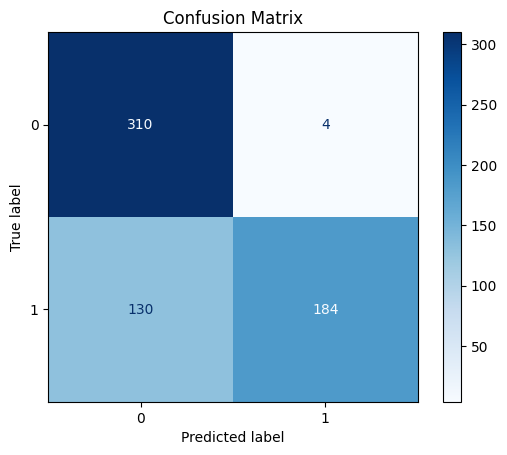

In [54]:
# Gerar a matriz de confusão
plot_confusion_matrix(y_test, y_pred)

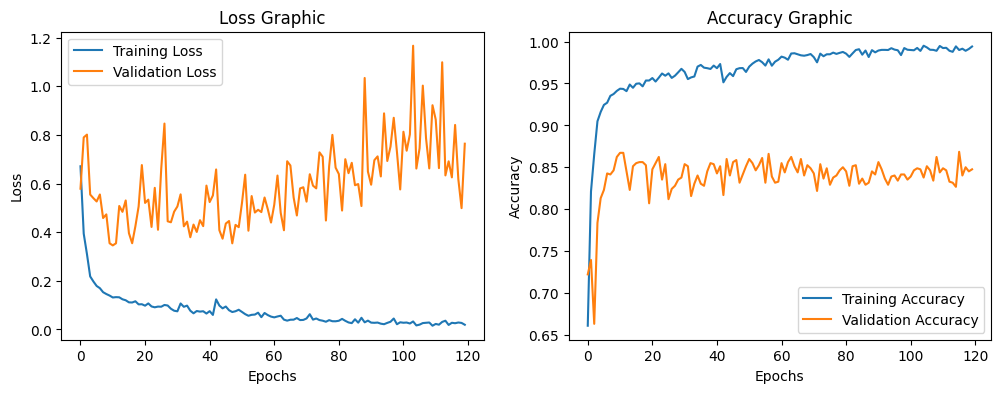

In [55]:
# Plotar o histórico do treinamento
plot_training_history(history)

Processando imagem 1 de 464


C:\Users\Gabriel Panza\AppData\Local\Temp\ipykernel_17924\3332370946.py:4: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed in 3.10.
  with PdfPages(pdf_path) as pdf:


FileNotFoundError: [Errno 2] No such file or directory: 'Pdf/Pacientes_Conjunto_Teste.pdf'

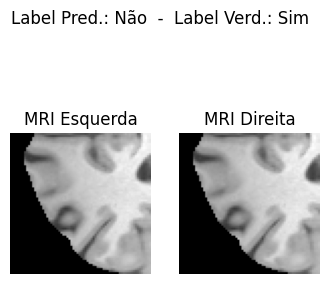

In [ ]:
# Função para plotar e salvar as imagens com legenda no PDF
def plot_images_to_pdf(X_test_left, X_test_right, y_test, pdf_path='Pdf/Pacientes_Conjunto_Teste.pdf'):
    # Abre o arquivo PDF para escrita
    with PdfPages(pdf_path) as pdf:
        for i in range(len(y_test)):
            # Exibe progresso
            print(f"Processando imagem {i + 1} de {len(y_pred)}")

            # Configuração da figura
            fig, axs = plt.subplots(1, 2, figsize=(4, 4))
            fig.suptitle(f'Label Pred.: {"Sim" if y_pred[i] == 1 else "Não"}  -  Label Verd.: {"Sim" if y_test[i] == 1 else "Não"}')

            # Exibe as imagens
            axs[0].imshow(X_test_left[i], cmap='gray')
            axs[0].set_title('MRI Esquerda')
            axs[0].axis('off')

            axs[1].imshow(X_test_right[i], cmap='gray')
            axs[1].set_title('MRI Direita')
            axs[1].axis('off')

            # Adiciona a figura atual ao PDF
            pdf.savefig(fig)
            plt.close(fig)

    print(f"As imagens foram salvas no arquivo PDF '{pdf_path}' com sucesso.")

# Chame a função com seus dados
plot_images_to_pdf(X_test_left, X_test_right, y_test)